In [1]:
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.io import loadmat

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal
from fooof import FOOOF

from timescales.fit import convert_knee_val, fit_psd
from timescales.sim import sim_spikes_synaptic
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows

from tqdm.notebook import tqdm

### Spikes vs LFP

This notebook uses the fcx1 dataset to compare timescales from spike counts and LFPs.

#### Spikes
The timescales, as knee frequencies, are compared between 4 types:

- Wake : Excitatory Units
- NREM : Excitatory Units
- Wake : Inhibitory Units
- NREM : Inhibitory Units

#### LFP
The LFP analysis is the same as past analysis, but uses the mPFC recordings, rather than hippocampal. This is because spikes were only sorted for the mPFC signals by the original authors and the signals were downsampled, so spike sorting can't be re-ran.

#### Comparison
For wake periods, timescales do not significantly different between spikes vs LFPs. But there is a significiant difference between spikes vs LFPs in the NREM trials.

In [2]:
def compute_spectra_trials(spikes_e, spikes_i, start_end, f_range, bin_size, ar_order,
                           kwargs_welch=None, kwargs_ar=None, mean=None, variance=None):
    """Compute Welch's and AR PSD for exciatatory and inhibitory spikes."""
    
    # Ensure unpackable
    if kwargs_welch is None:
        kwargs_welch = {}
    if kwargs_ar is None:
        kwargs_ar = {}
            
    # Compute AR-PSD and Welch's-PSD for each window
    for ind, (s, e) in enumerate(start_end):

        # Normalize
        spikes_bin_e = normalize_sig(
            spikes_e[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        spikes_bin_i = normalize_sig(
            spikes_i[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        # Compute excitatory spectra
        freqs_ar, _powers_ar_e = compute_ar_spectrum(spikes_bin_e, fs/bin_size, ar_order,
                                                     f_range=f_range, **kwargs_ar)
        
        freqs_welch, _powers_welch_e = compute_spectrum(spikes_bin_e, fs/bin_size,
                                                        f_range=f_range, **kwargs_welch)
        
        # Compute inhibitory spectra
        _, _powers_ar_i = compute_ar_spectrum(spikes_bin_i, fs/bin_size, ar_order,
                                              f_range=f_range, **kwargs_ar)
        
        _, _powers_welch_i = compute_spectrum(spikes_bin_i, fs/bin_size,
                                              f_range=f_range, **kwargs_welch)
        
        # Initalize arrays
        if ind == 0:
            
            freqs = {'welch': freqs_welch, 'ar': freqs_ar}
            
            powers = {
                'ar': {'excitatory': np.zeros((len(start_end), len(_powers_ar_e))),
                       'inhibitory': np.zeros((len(start_end), len(_powers_ar_i)))},
                'welch': {'excitatory': np.zeros((len(start_end), len(_powers_welch_e))),
                          'inhibitory': np.zeros((len(start_end), len(_powers_welch_i)))}
            }
            
        if mean is not None and variance is not None:
            _powers_ar_e = normalize_sig(_powers_ar_e, mean, variance)
            _powers_welch_e = normalize_sig(_powers_welch_e, mean, variance)
            _powers_ar_i = normalize_sig(_powers_ar_i, mean, variance)
            _powers_welch_i = normalize_sig(_powers_welch_i, mean, variance)
        
        powers['ar']['excitatory'][ind] = _powers_ar_e
        powers['welch']['excitatory'][ind] = _powers_welch_e
        powers['ar']['inhibitory'][ind] = _powers_ar_i
        powers['welch']['inhibitory'][ind] = _powers_welch_i
        
    return freqs, powers

In [32]:
# Load data
base_name = '20140526_277um'
dir_path = f'/home/rph/Projects/timescale-methods/fcx1/{base_name}'

subtype_dict = loadmat(f'{dir_path}/{base_name}_SSubtypes.mat')
subtype_e = subtype_dict['Se_CellFormat'][0]
subtype_i = subtype_dict['Si_CellFormat'][0]

fs = 20000

n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                         *[np.max(i) for i in subtype_e]]))

times = np.arange(0, n_seconds, 1/fs)

# Extract behavioral data
beh_file = f'{dir_path}/{base_name}_WSRestrictedIntervals.mat'
beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) *  fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

In [35]:
# Sum spikes across E/I sub-units
spikes_e = np.zeros(int(n_seconds * fs))
for s in subtype_e:
    
    st = s[:, 0] * fs
    st = st[np.where(st <= len(spikes_e))[0]]

    spikes_e[st.astype(int)] = 1
         
spikes_i = np.zeros(int(n_seconds * fs))
for s in subtype_i:
    
    st = s[:, 0] * fs
    st = st[np.where(st <= len(spikes_i))[0]]

    spikes_i[st.astype(int)] = 1
    
# Compute Spectra
f_range = (0, 100)
bin_size = 200
ar_order = 5

kwargs_welch = {'nperseg': 2*fs/bin_size}

freqs_wake, powers_wake = compute_spectra_trials(
    spikes_e, spikes_i, start_end_wake, f_range, bin_size, ar_order, kwargs_welch=kwargs_welch)

freqs_nrem, powers_nrem = compute_spectra_trials(
    spikes_e, spikes_i, start_end_nrem, f_range, bin_size, ar_order, kwargs_welch=kwargs_welch)

In [36]:
# Fit FOOOF
fooof_init = {
    'aperiodic_mode': 'knee_constant',                # allows tapering
    'max_n_peaks': 4,
    'peak_threshold': 2.5,
    'curve_kwargs': dict(loss='cauchy', f_scale=1e-3) # more robust regression
}

ap_bounds = [
    [-10,  0,       0, 1e-10],
    [ 10, 10,  np.inf, np.inf]
]

ap_guess = [0, (ap_bounds[1][1] - ap_bounds[0][1])/2, 2, 1]

with warnings.catch_warnings():
    
    # Poor fits raise warning when computing r-squared
    warnings.simplefilter("ignore")
    
    fm_ar_ex_wake, k_ar_ex_wake = fit_psd(freqs_wake['ar'], powers_wake['ar']['excitatory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)

    fm_ar_in_wake, k_ar_in_wake = fit_psd(freqs_wake['ar'], powers_wake['ar']['inhibitory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)
    
    fm_ar_ex_nrem, k_ar_ex_nrem = fit_psd(freqs_nrem['ar'], powers_nrem['ar']['excitatory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)

    fm_ar_in_nrem, k_ar_in_nrem = fit_psd(freqs_nrem['ar'], powers_nrem['ar']['inhibitory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)

Running FOOOFGroup:   0%|          | 0/429 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/429 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/562 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/562 [00:00<?, ?it/s]

In [37]:
# Remove low r-squared fits
def filter_fits(rsqs, rsq_thresh):
    return np.where(rsqs >= rsq_thresh)[0]

inds_ar_ex_wake = filter_fits(fm_ar_ex_wake.get_params('r_squared'), .8)
inds_ar_in_wake = filter_fits(fm_ar_in_wake.get_params('r_squared'), .8)
inds_ar_ex_nrem = filter_fits(fm_ar_ex_nrem.get_params('r_squared'), .8)
inds_ar_in_nrem = filter_fits(fm_ar_in_nrem.get_params('r_squared'), .8)

print('ex wake: ' + str(len(inds_ar_ex_wake)))
print('in wake: ' + str(len(inds_ar_in_wake)))
print('ex nrem: ' + str(len(inds_ar_ex_nrem)))
print('in nrem: ' + str(len(inds_ar_in_nrem)))

ex wake: 243
in wake: 178
ex nrem: 492
in nrem: 509


Text(0.5, 1.0, 'Inhibitory NREM')

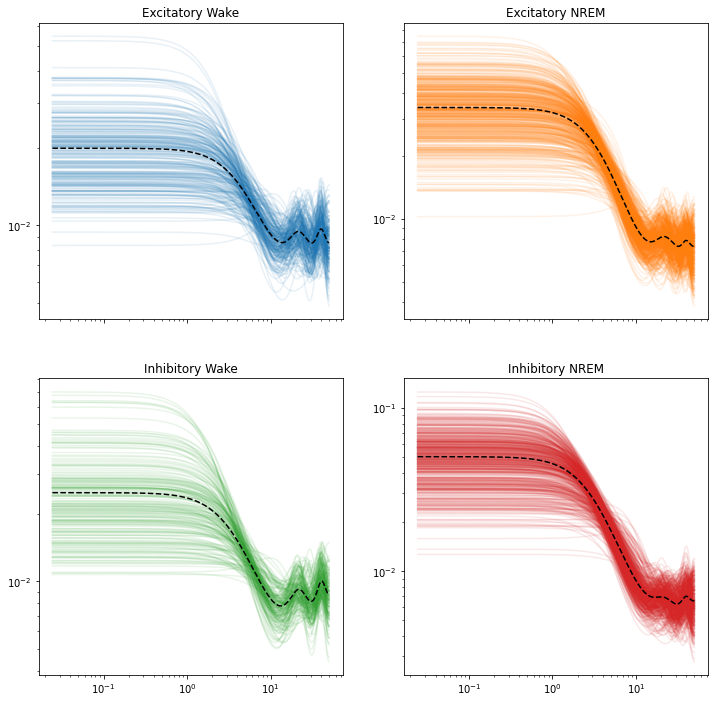

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True)

# Excitatory
for p in powers_wake['ar']['excitatory'][inds_ar_ex_wake, 1:]:
    axes[0][0].loglog(freqs_wake['ar'][1:], p, color='C0', alpha=.1)
    
axes[0][0].loglog(freqs_wake['ar'][1:],
                  powers_wake['ar']['excitatory'][inds_ar_ex_wake, 1:].mean(axis=0),
                  color='k', ls='--')
    
for p in powers_nrem['ar']['excitatory'][inds_ar_ex_nrem, 1:]:
    axes[0][1].loglog(freqs_nrem['ar'][1:], p, color='C1', alpha=.1)
    
axes[0][1].loglog(freqs_nrem['ar'][1:],
                  powers_nrem['ar']['excitatory'][inds_ar_ex_nrem, 1:].mean(axis=0),
                  color='k', ls='--')

# Inhibitory
for p in powers_wake['ar']['inhibitory'][inds_ar_in_wake, 1:]:
    axes[1][0].loglog(freqs_wake['ar'][1:], p, color='C2', alpha=.1)
    
axes[1][0].loglog(freqs_wake['ar'][1:],
                  powers_wake['ar']['inhibitory'][inds_ar_in_wake, 1:].mean(axis=0),
                  color='k', ls='--')

for p in powers_nrem['ar']['inhibitory'][inds_ar_in_nrem, 1:]:
    axes[1][1].loglog(freqs_nrem['ar'][1:], p, color='C3', alpha=.1)
    
axes[1][1].loglog(freqs_nrem['ar'][1:],
                  powers_nrem['ar']['inhibitory'][inds_ar_in_nrem, 1:].mean(axis=0),
                  color='k', ls='--')

# Labels
axes[0][0].set_title('Excitatory Wake')
axes[0][1].set_title('Excitatory NREM')
axes[1][0].set_title('Inhibitory Wake')
axes[1][1].set_title('Inhibitory NREM')

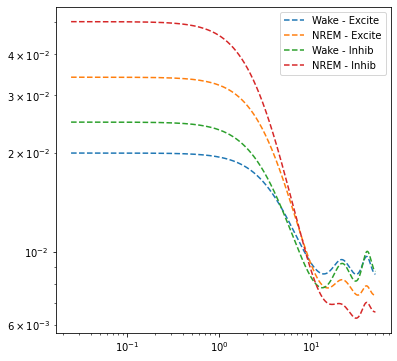

In [39]:
fig, ax = plt.subplots(figsize=(6, 6), sharex=True)

# Excitatory
ax.loglog(freqs_wake['ar'][1:],
          powers_wake['ar']['excitatory'][inds_ar_ex_wake, 1:].mean(axis=0),
          color='C0', ls='--', label='Wake - Excite')

ax.loglog(freqs_nrem['ar'][1:],
          powers_nrem['ar']['excitatory'][inds_ar_ex_nrem, 1:].mean(axis=0),
          color='C1', ls='--', label='NREM - Excite')

# Inhibitory
ax.loglog(freqs_wake['ar'][1:],
          powers_wake['ar']['inhibitory'][inds_ar_in_wake, 1:].mean(axis=0),
          color='C2', ls='--', label='Wake - Inhib')

ax.loglog(freqs_nrem['ar'][1:],
          powers_nrem['ar']['inhibitory'][inds_ar_in_nrem, 1:].mean(axis=0),
          color='C3', ls='--', label='NREM - Inhib')
plt.legend();

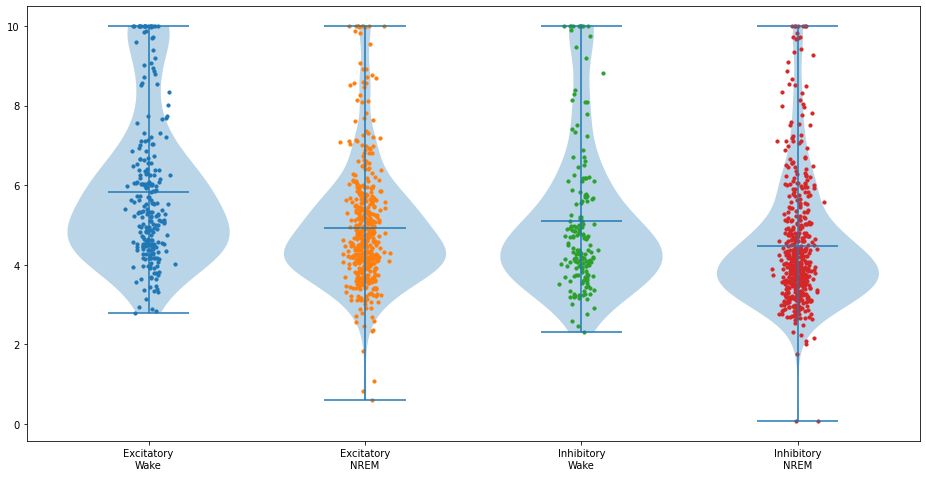

In [40]:
plt.figure(figsize=(16, 8))

xlocs = np.linspace(1, 3, 4)

ds = [k_ar_ex_wake[inds_ar_ex_wake], k_ar_ex_nrem[inds_ar_ex_nrem], 
      k_ar_in_wake[inds_ar_in_wake], k_ar_in_nrem[inds_ar_in_nrem]]

plt.violinplot(ds, showmeans=True, positions=xlocs)

for dat, loc in zip(ds, xlocs):
    _xlocs = np.random.normal(loc, .025, len(dat))
    plt.scatter(_xlocs, dat, s=10)

plt.xticks(xlocs, labels=['Excitatory\nWake', 'Excitatory\nNREM', 'Inhibitory\nWake', 'Inhibitory\nNREM']);

In [41]:
from scipy.stats import ttest_ind

print('Wake E.', ds[0].mean(), ds[0].std())
print('NREM E.', ds[1].mean(), ds[1].std())
print('Wake I.', ds[2].mean(), ds[2].std())
print('NREM I.', ds[3].mean(), ds[3].std())
print()

# Wake vs NREM - Excitatory
print(ttest_ind(ds[0], ds[1]))

# Wake vs NREM - Inhibitory
print(ttest_ind(ds[2], ds[3]))

# Excitatory vs Inhibitory - Wake
print(ttest_ind(ds[0], ds[2]))

# Excitatory vs Inhibitory - NREM
print(ttest_ind(ds[1], ds[3]))

Wake E. 5.817643846221694 1.8560747273830882
NREM E. 4.9189642491613945 1.5017299029645208
Wake I. 5.094534167916805 1.8576844094999139
NREM I. 4.475630150703894 1.5849520834141317

Ttest_indResult(statistic=7.0331543269334444, pvalue=4.6358419503497795e-12)
Ttest_indResult(statistic=4.2755578715047875, pvalue=2.177261382775123e-05)
Ttest_indResult(statistic=3.9381070234153635, pvalue=9.616947750984244e-05)
Ttest_indResult(statistic=4.5352677824255005, pvalue=6.450658987624363e-06)


In [42]:
from functools import partial
from multiprocessing import Pool, cpu_count

import os.path as op

import numpy as np
from scipy.io import loadmat

#from timescales.mp import compute_taus
from timescales.fit import convert_knee_val
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows, get_distinct_windows

In [43]:
def _fit_windows(start_end, sig=None):
    
    # Settings
    ar_order = 5
    f_range = (0, 100)
    fooof_init = {'max_n_peaks': 5, 'peak_threshold':2.5}
    
    start, end = start_end[0], start_end[1]
    
    sig_win = sig[start:end]
    
    freqs_ar, powers_ar = compute_ar_spectrum(sig_win, fs, ar_order)
    freqs_welch, powers_welch = compute_spectrum(sig_win, fs)
    
    fm_ar, _ = fit_psd(freqs_ar, powers_ar, f_range, fooof_init, f_range, n_jobs=1)
    fm_welch, _ = fit_psd(freqs_welch, powers_welch, f_range, fooof_init, f_range, n_jobs=1)

    return fm_welch, fm_ar

In [44]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'
fs = 1250

# Infer shape using one channel
lfp_file = op.join(data_dir, 'data01.mat')
sig_len = len(loadmat(lfp_file)['data'][0])

# Get PFC channels
channels = list(range(17, 49))
sig_lfp = np.zeros(sig_len)

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = loadmat(lfp_file)['data'][0]
    sig_lfp += _sig_lfp
    
del _sig_lfp

sig_lfp = sig_lfp / len(channels)
sig_lfp =  normalize_sig(sig_lfp, 0, 1)
#sig_lfp = filter_signal(sig_lfp, fs, )

times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Windows
nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

In [45]:
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end_wake)
    
    results = list(tqdm(mapping, total=len(start_end_wake)))
    
fm_wake_welch = np.array([i[0] for i in results])
fm_wake_ar = np.array([i[1] for i in results])

  0%|          | 0/429 [00:00<?, ?it/s]

In [46]:
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end_nrem)
    
    results = list(tqdm(mapping, total=len(start_end_nrem)))
    
fm_nrem_welch = np.array([i[0] for i in results])
fm_nrem_ar = np.array([i[1] for i in results])

  0%|          | 0/562 [00:00<?, ?it/s]

In [53]:
from fooof.objs import combine_fooofs

fm_wake_ar = combine_fooofs(fm_wake_ar)
fm_nrem_ar = combine_fooofs(fm_nrem_ar)

In [54]:
knees_wake_ar_lfp = fm_nrem_ar.get_params('aperiodic', 'knee')
knees_nrem_ar_lfp = fm_nrem_ar.get_params('aperiodic', 'knee')

inds_ar_wake_lfp = filter_fits(fm_wake_ar.get_params('r_squared'), .8)
inds_ar_nrem_lfp = filter_fits(fm_nrem_ar.get_params('r_squared'), .8)

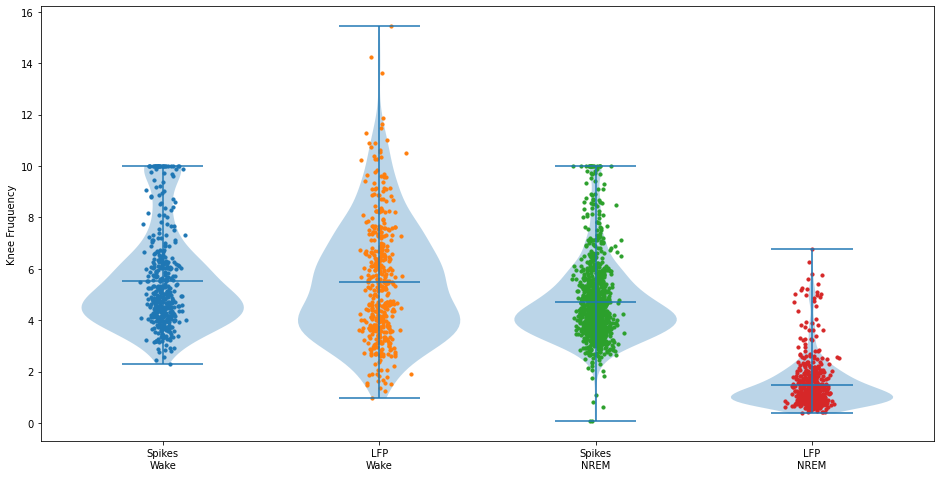

In [56]:
plt.figure(figsize=(16, 8))

k_ar_wake = np.concatenate((k_ar_ex_wake[inds_ar_ex_wake], k_ar_in_wake[inds_ar_in_wake]))
k_ar_nrem = np.concatenate((k_ar_ex_nrem[inds_ar_ex_nrem], k_ar_in_nrem[inds_ar_in_nrem]))

ds = [k_ar_wake, knees_wake_ar[inds_ar_wake_lfp],
      k_ar_nrem, knees_nrem_ar[inds_ar_nrem_lfp]]

plt.violinplot(ds, showmeans=True, positions=xlocs)

for dat, loc in zip(ds, xlocs):
    _xlocs = np.random.normal(loc, .025, len(dat))
    plt.scatter(_xlocs, dat, s=10)

plt.ylabel('Knee Fruquency')
plt.xticks(xlocs, labels=['Spikes\nWake', 'LFP\nWake',  'Spikes\nNREM', 'LFP\nNREM']);

In [57]:
# Wake : Spikes vs LFP
print(ttest_ind(ds[0], ds[1]))

# NREM : Spieks vs LFP
print(ttest_ind(ds[2], ds[3]))

Ttest_indResult(statistic=0.22534071244521386, pvalue=0.8217685228330615)
Ttest_indResult(statistic=44.10280942562063, pvalue=1.4209220178968245e-276)
